#Download Dataset from Kaggle

In [ ]:
# COPY DATASET LINK FROM KAGGLE AND PASTE HERE

In [ ]:
!unzip eye-diseases-classification.zip -q

Archive:  eye-diseases-classification.zip
caution: filename not matched:  -q


#Install requirements and Import

In [ ]:
!pip install torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 19.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
from torchvision import datasets
import warnings
warnings.filterwarnings('ignore')
from torchvision.utils import make_grid


#Data Transformation

In [ ]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets (assuming your data is structured in subdirectories for each class)
dataset = datasets.ImageFolder(root='dataset', transform=train_transform)





In [ ]:
no_of_classes=len(set(dataset.targets))

In [ ]:
print(no_of_classes)

4


#Displaying Images

Label : cataract


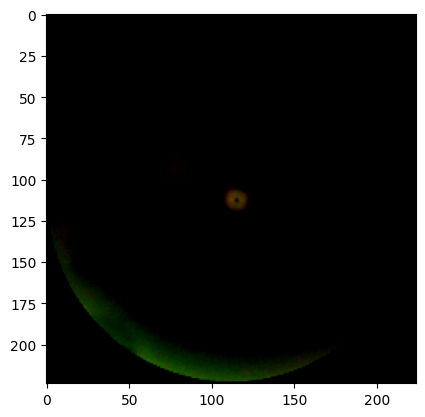

In [ ]:
def display_image(image, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(image.permute(1, 2, 0))


# display the first image in the dataset
display_image(*dataset[0])

#Splitting Data

In [ ]:
def train_test_split(dataset, train_size, random_state=42):
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    seed = torch.Generator().manual_seed(random_state)
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], generator=seed
    )

    return train_dataset, test_dataset

In [ ]:
train_dataset, test_dataset = train_test_split(dataset, 0.8)

#Displaying BatchImages

In [ ]:
batch_size = 32
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

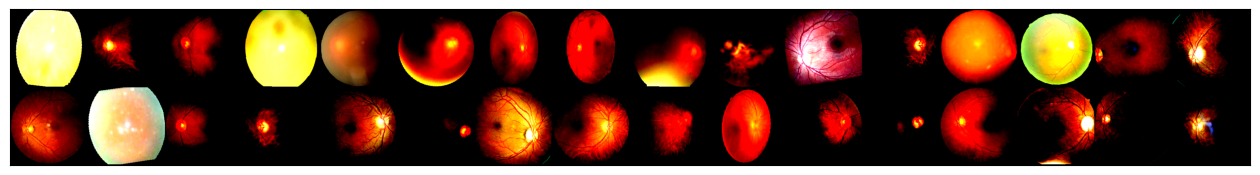

In [ ]:
def show_batch(data_loader):
    """Plot images grid of single batch"""
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


show_batch(train_loader)

#MODEL

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)


num_features = model.fc.in_features
model.fc = nn.Linear(num_features, no_of_classes)
# Move the model to GPU if available
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


In [ ]:
# Define loss function and optimizer
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/10], Train Loss: 0.5401, Test Loss: 0.6416, Train Acc: 76.02%, Test Acc: 75.36%
Epoch [2/10], Train Loss: 0.4031, Test Loss: 0.5898, Train Acc: 80.52%, Test Acc: 80.09%
Epoch [3/10], Train Loss: 0.3299, Test Loss: 0.5372, Train Acc: 81.09%, Test Acc: 79.38%
Epoch [4/10], Train Loss: 0.2893, Test Loss: 0.7127, Train Acc: 77.41%, Test Acc: 75.47%
Epoch [5/10], Train Loss: 0.3191, Test Loss: 0.4354, Train Acc: 87.31%, Test Acc: 85.07%
Epoch [6/10], Train Loss: 0.2854, Test Loss: 0.4292, Train Acc: 87.79%, Test Acc: 86.26%
Epoch [7/10], Train Loss: 0.2676, Test Loss: 0.2513, Train Acc: 91.31%, Test Acc: 90.52%
Epoch [8/10], Train Loss: 0.2506, Test Loss: 0.3250, Train Acc: 89.92%, Test Acc: 86.14%
Epoch [9/10], Train Loss: 0.2270, Test Loss: 0.2744, Train Acc: 91.25%, Test Acc: 90.05%
Epoch [10/10], Train Loss: 0.2397, Test Loss: 0.4071, Train Acc: 88.38%, Test Acc: 84.24%


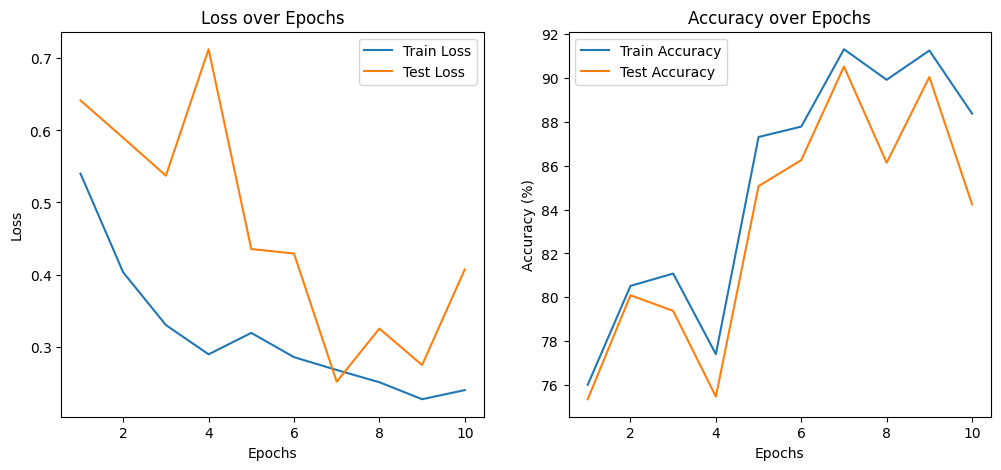

In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs=10

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()  # Evaluation mode
    correct = total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training and validation loop
for epoch in tqdm(range(num_epochs)):
    model.train()  # Training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Calculate accuracy for train and test sets
    train_accuracy = calculate_accuracy(train_loader, model)
    test_accuracy = calculate_accuracy(test_loader, model)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # Calculate test loss
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
          f'Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

# Plot losses and accuracies
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

#Save the Model

In [ ]:
# Save the trained model as 'resnet50_eye_disease.pth'
torch.save(model.state_dict(), 'resnet50_eye_disease.pth')

# Download the saved model to your local machine (Optional)
from google.colab import files
files.download('resnet50_eye_disease.pth')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Streamlit Application

In [ ]:
!pip install streamlit -q
!pip install pyngrok -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
# Define device configuration (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained ResNet-50 model and move it to the correct device
@st.cache_resource
def load_model():
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 4)  # Adjust for 4 classes
    model.load_state_dict(torch.load('resnet50_eye_disease.pth', map_location=device))
    model.to(device)  # Move model to the correct device
    model.eval()
    return model

model = load_model()

# Streamlit UI for uploading and predicting eye diseases
st.title("Eye Disease Prediction using ResNet-50")
st.write("Upload an eye image, and the model will predict the disease.")

uploaded_file = st.file_uploader("Upload an eye image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Transform the image and move it to the correct device
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make a prediction
    with torch.no_grad():
        outputs = model(img_tensor)  # Model and input are on the same device
        _, predicted = torch.max(outputs, 1)
        class_names = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']  # Update class names
        predicted_class = class_names[predicted.item()]

    # Display the prediction result
    st.write(f"**Prediction:** {predicted_class}")




Overwriting app.py


In [ ]:
!ngrok config add-authtoken #your ngrok authtoken paste here

In [ ]:
from pyngrok import ngrok

# Start the Streamlit app in the background
!streamlit run app.py &>/dev/null &

# Expose the app on a public URL
public_url = ngrok.connect(8501)
print(f"Streamlit app is live at: {public_url}")
